# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using  the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [2]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q7l/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-14 22:12:38]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-14 22:12:39]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [3]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)}%.")

VQE energy is -14.856898957126564. 
The target energy is -15.276131122065795 which means the difference is 0.4192321649392312.
The relative difference is 0.02744360869838739%.


# 2. 3 GCI3 steps for fixed
$D= \sum_i B_i Z_i$
and Group commutator

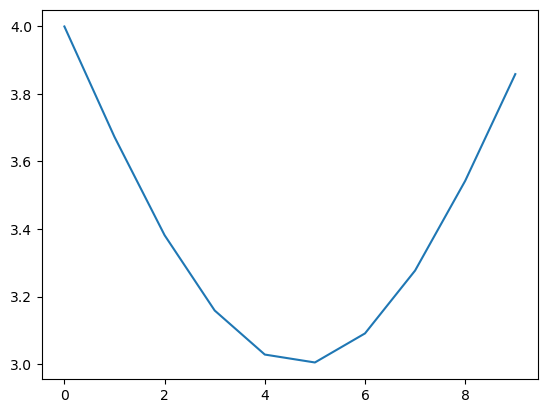

In [4]:
b_list = [4-np.sin(i/3) for i,x in enumerate(np.random.rand(10)) ]
                                  
plt.plot(b_list)

In [24]:
from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 1, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)

gci.print_gate_count_report()

The boosting circuit used 0 CNOT gates coming from compiled XXZ evolution and 70 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 0.0 and n_CZ/n_qubits = 7.0


-14.984190461023942
-14.984190461023942


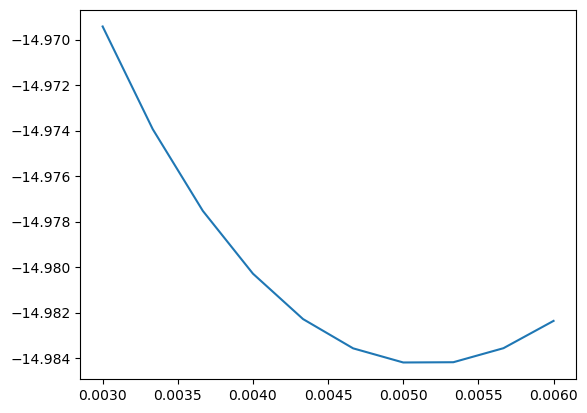

In [25]:
# init the generator of the evolution,
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
eo_d = MagneticFieldEvolutionOracle(b_list,name = "D(linear)")
times = np.linspace( 0.003,0.006,10)
step,loss, losses = gci.choose_step(d = eo_d,times = times)
print(loss)

plt.plot(times,losses)
#plt.yticks([losses[0],losses[np.argmin(losses)]])
#plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gc3 = times[np.argmin(losses)]


In [26]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0


-15.032482093194144
-15.032482093194144


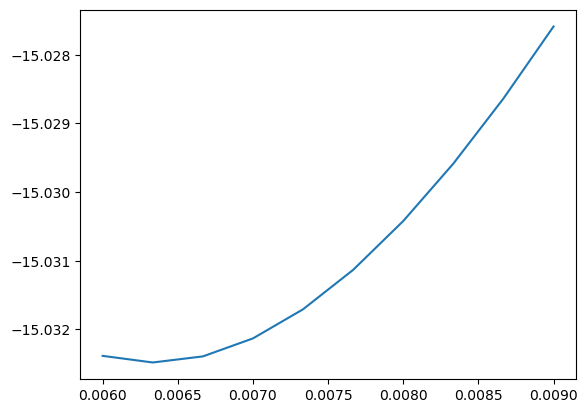

In [29]:
eo_d = MagneticFieldEvolutionOracle(b_list,name = "D(linear)")
times = np.linspace( 0.006,0.009,10)
step,loss, losses = gci.choose_step(d = eo_d,times = times)
print(loss)

plt.plot(times,losses)
#plt.yticks([losses[0],losses[np.argmin(losses)]])
#plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gc3 = times[np.argmin(losses)]

In [30]:
print(gci.loss())
print(gci.loss(step, eo_d))
gci.print_gate_count_report()
gci(step, eo_d)
print(gci.loss())
gci.print_gate_count_report()

-14.984190461023942
-15.032482093194144
The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0
-15.032482093194144


-15.05784952396699
-15.05784952396699


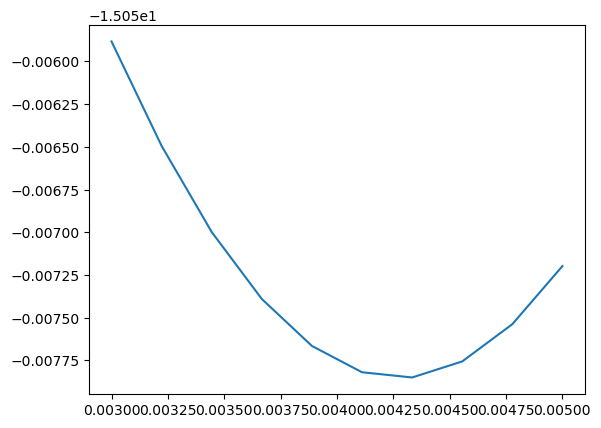

In [33]:
eo_d = MagneticFieldEvolutionOracle(b_list,name = "D(linear)")
times = np.linspace( 0.003,0.005,10)
step,loss, losses = gci.choose_step(d = eo_d,times = times)
print(loss)

plt.plot(times,losses)
#plt.yticks([losses[0],losses[np.argmin(losses)]])
#plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gc3 = times[np.argmin(losses)]

In [34]:
print(gci.loss())
print(gci.loss(step, eo_d))
gci.print_gate_count_report()
gci(step, eo_d)
print(gci.loss())
gci.print_gate_count_report()

-15.032482093194144
-15.05784952396699
The boosting circuit used 540 CNOT gates coming from compiled XXZ evolution and 1750 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 54.0 and n_CZ/n_qubits = 175.0
-15.05784952396699
The boosting circuit used 2790 CNOT gates coming from compiled XXZ evolution and 8750 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 279.0 and n_CZ/n_qubits = 875.0


-14.976229936849197


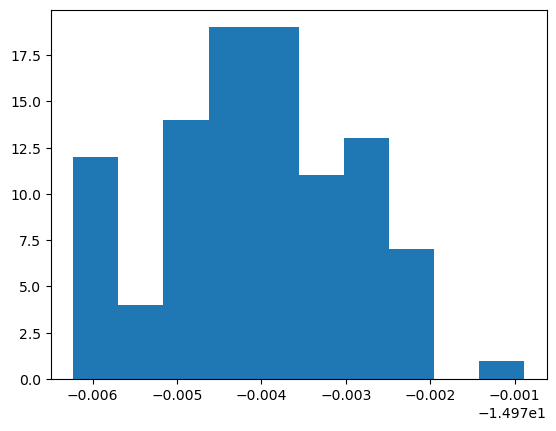

In [36]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
for j in range(100):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss, _ = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))
f = fields[np.argmin(losses)]
s = steps[np.argmin(losses)]

-14.983910766478111


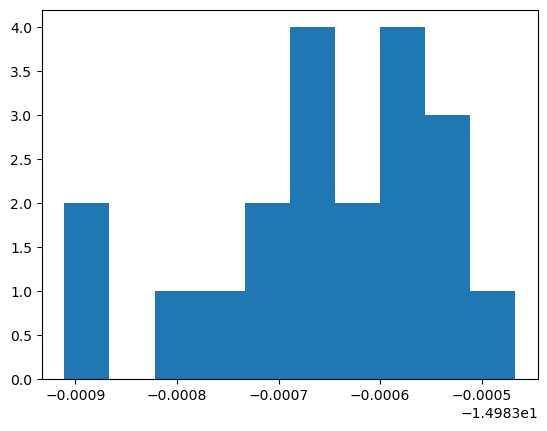

In [67]:
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
fields = []
losses = []
steps = []
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
for j in range(20):
    field = [a+b for a,b in zip(np.random.rand(10)*.1,b_list)]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss, _ = gci2.choose_step(d = eo_d,max_evals=30,step_min = 0.001,step_max = 0.01)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))
f3 = fields[np.argmin(losses)]
s = steps[np.argmin(losses)]

(array([18.,  0.,  0., 47.,  0.,  0., 30.,  0.,  0.,  5.]),
 array([0.01943636, 0.01966273, 0.01988909, 0.02011545, 0.02034182,
        0.02056818, 0.02079455, 0.02102091, 0.02124727, 0.02147364,
        0.0217    ]),
 <BarContainer object of 10 artists>)

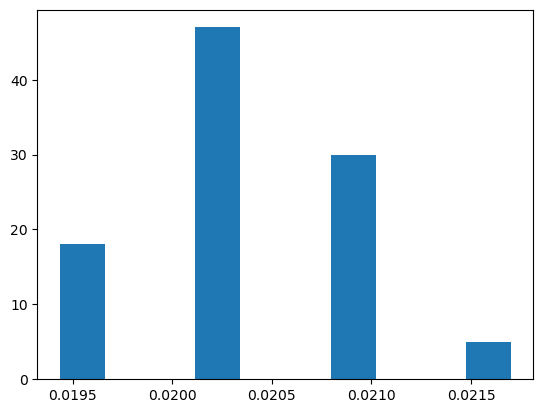

In [38]:
plt.hist(steps)

In [64]:
d_params_test, s, min_loss = gradient_descent_circuits(
gci2,
 train_epochs=10,
   d_params_init=f2,
   lr=10
)

-14.976206820097918
0
-14.97863322532625
1
-14.978212788281898
2
-14.978345322048918
3
-14.978285855536484
4
-14.978316705984422
5
-14.978300396659915
6
-14.97830912563686
7
-14.978304462271376
8
-14.978306958600346
9
-14.97830562343949


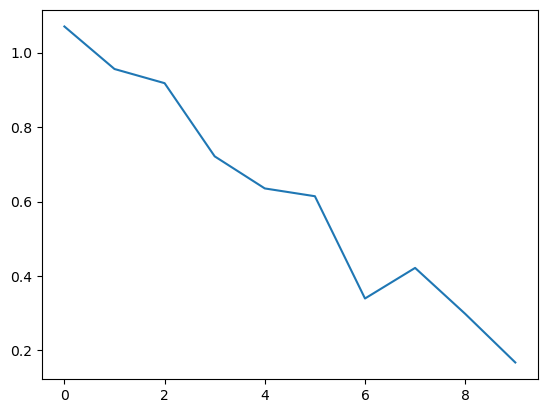

In [65]:
plt.plot(f)

In [ ]:
s,loss = gci.choose_step(d = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ),step_max=0.007,step_min=0.003, max_evals=64)

In [ ]:
gci(s, params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ))


In [ ]:
loss

-14.984262401527271

In [ ]:
step,loss = gci.choose_step(d = eo_d,step_max=0.007,step_min=0.003, max_evals=64)

In [ ]:
step

0.0061111111111111106

In [ ]:
loss

-15.03199796593811

In [ ]:
d_params_test2, s, min_loss = gradient_descent_circuits(
gci,
 train_epochs=2,
   d_params_init=np.random.rand(10),
   lr=.01
)

-15.0319979962218
0
-14.989159605755157
1
-15.00315996093362


In [ ]:
d_params_test3, s, min_loss = gradient_descent_circuits(
gci,
 train_epochs=6,
   d_params_init=d_params_test2,
   lr=.01
)

-15.0319979962218
0
-14.98916290692736
1
-15.003161832059906
2
-15.003161354487506
3
-15.003161354507414
4
-15.003161354507405
5
-15.003161354507506


In [ ]:
np.max(np.array(d_params_test) - np.array(b_list))

-9.46347320507357e-06

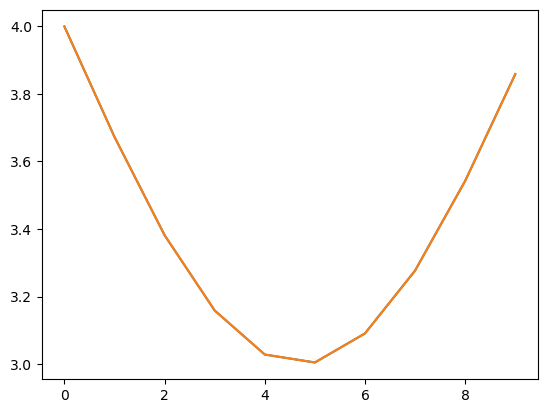

In [ ]:
plt.plot(d_params_test)
plt.plot(b_list)

In [ ]:
step,loss = gci.choose_step(d = eo_d,step_min=0.0001,step_max=1.15*0.01, max_evals=25)

In [ ]:
loss

-15.031976326074851

In [ ]:
step

0.006275

In [ ]:
step,loss = gci.choose_step(d = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ),step_min=0.003,step_max=1.15*0.01, max_evals=85)

In [ ]:
loss

-15.031997828897188

In [ ]:
step

0.006136904761904762

In [ ]:
m = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ).h.dense.matrix

[Qibo 0.2.9|WARNING|2024-06-13 00:03:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [ ]:
D = np.diag(m)

In [ ]:
hvqe_matrix = rotate_h_with_vqe(hamiltonian=hamiltonian, vqe=vqe)

In [ ]:
Dvqe = np.diag(hvqe_matrix)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


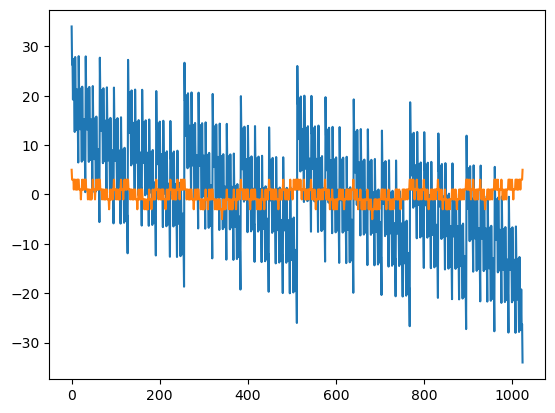

In [ ]:
plt.plot(D)
plt.plot(Dvqe)

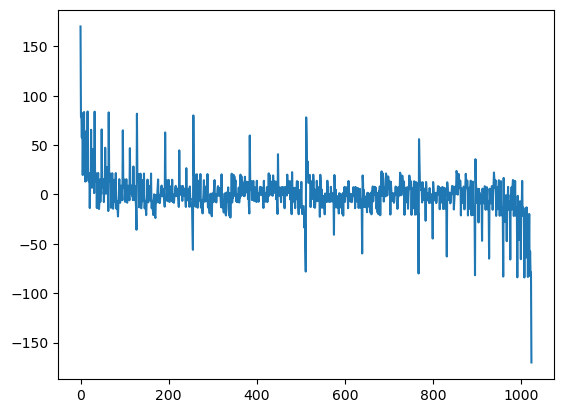

In [ ]:
plt.plot([x*y for x,y in zip(Dvqe,D)])

In [ ]:
np.sum([x*y for x,y in zip(Dvqe,D)])

0j

In [ ]:

hvqe_matrix.shape


(1024, 1024)

In [ ]:
SymbolicHamiltonian(symbols.Z(0),nqubits=nqubits).dense.matrix.shape

[Qibo 0.2.9|WARNING|2024-06-13 00:04:10]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


(1024, 1024)

In [ ]:
for i in range(nqubits):
    print(np.trace(hvqe_matrix@(SymbolicHamiltonian(symbols.Z(i)*symbols.Z(0),nqubits=nqubits).dense.matrix)))

[Qibo 0.2.9|WARNING|2024-06-13 00:04:10]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-06-13 00:04:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


(512+0j)


[Qibo 0.2.9|WARNING|2024-06-13 00:04:26]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:31]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:42]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:47]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:52]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j
(512+0j)
